# Load SEED Dataset

In [1]:
from utils.seed_dataset_loader import SeedDatasetLoader

loader = SeedDatasetLoader()

Going through files:   0%|          | 0/47 [00:00<?, ?it/s]

In [2]:
loader.get_labels()

array([[ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1]],
      dtype=int16)

In [3]:
loader.get_channel_order()

{0: 'FP1',
 1: 'FPZ',
 2: 'FP2',
 3: 'AF3',
 4: 'AF4',
 5: 'F7',
 6: 'F5',
 7: 'F3',
 8: 'F1',
 9: 'FZ',
 10: 'F2',
 11: 'F4',
 12: 'F6',
 13: 'F8',
 14: 'FT7',
 15: 'FC5',
 16: 'FC3',
 17: 'FC1',
 18: 'FCZ',
 19: 'FC2',
 20: 'FC4',
 21: 'FC6',
 22: 'FT8',
 23: 'T7',
 24: 'C5',
 25: 'C3',
 26: 'C1',
 27: 'CZ',
 28: 'C2',
 29: 'C4',
 30: 'C6',
 31: 'T8',
 32: 'TP7',
 33: 'CP5',
 34: 'CP3',
 35: 'CP1',
 36: 'CPZ',
 37: 'CP2',
 38: 'CP4',
 39: 'CP6',
 40: 'TP8',
 41: 'P7',
 42: 'P5',
 43: 'P3',
 44: 'P1',
 45: 'PZ',
 46: 'P2',
 47: 'P4',
 48: 'P6',
 49: 'P8',
 50: 'PO7',
 51: 'PO5',
 52: 'PO3',
 53: 'POZ',
 54: 'PO4',
 55: 'PO6',
 56: 'PO8',
 57: 'CB1',
 58: 'O1',
 59: 'OZ',
 60: 'O2',
 61: 'CB2'}

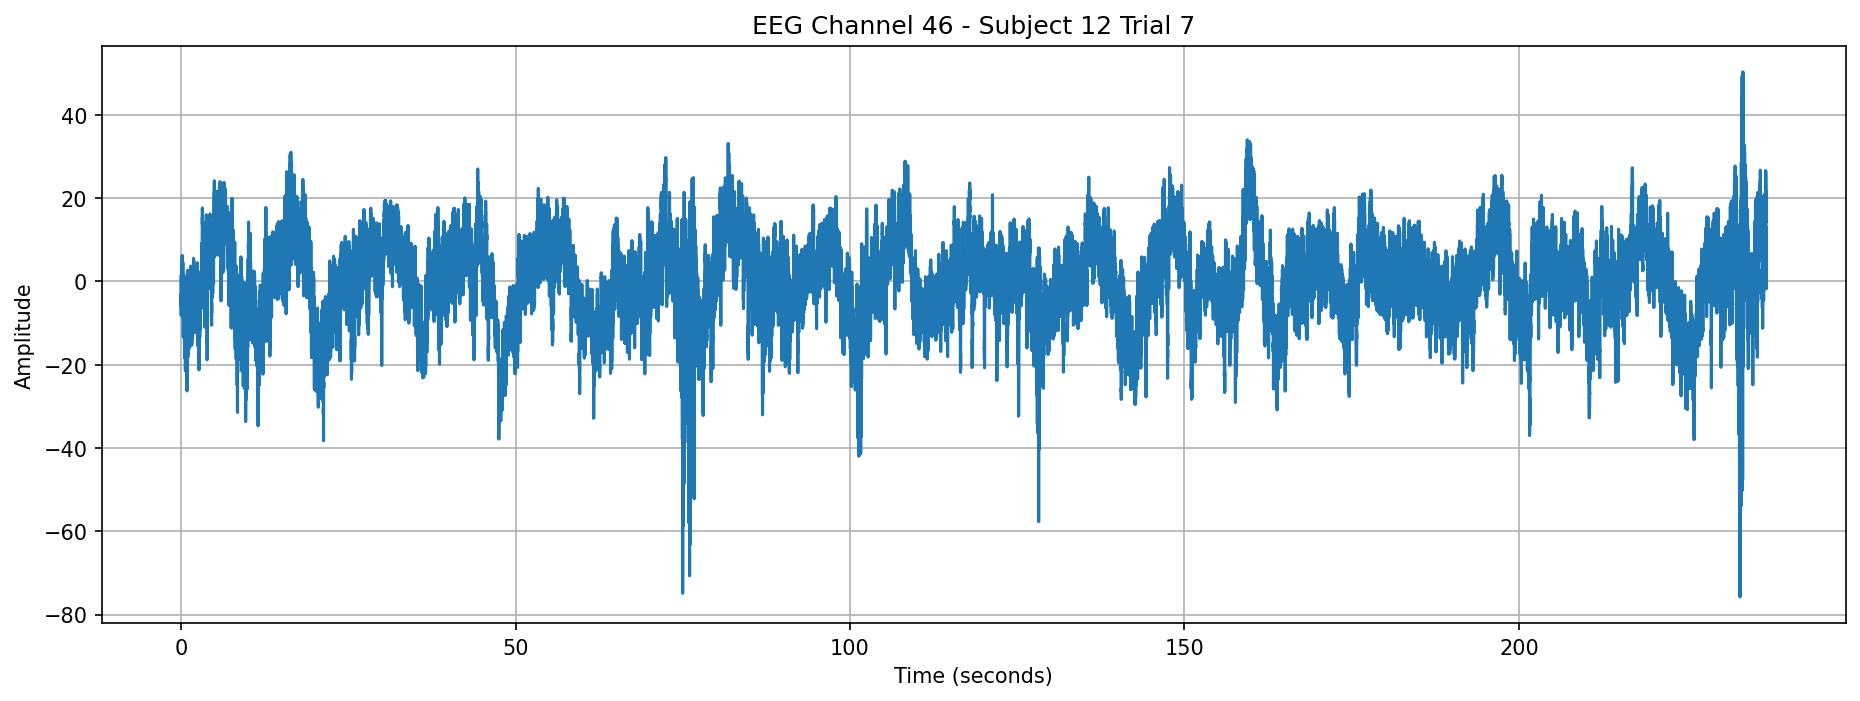

In [4]:
loader.plot_random_eeg()

# Data Augmentation

In [1]:
def time_domain_augmentation(x, noise_level=0.05):
    """
    Augments the time-domain EEG data by adding Gaussian noise.
    
    Parameters:
    - x (torch.Tensor): The input EEG signal tensor.
    - noise_level (float): Standard deviation of the Gaussian noise to be added.

    Returns:
    - torch.Tensor: Augmented EEG signal.
    """
    noise = torch.randn_like(x) * noise_level
    return x + noise


def fourier_transform(x):
    """
    Applies Fourier transformation to convert time-domain EEG signals into frequency spectra.
    
    Parameters:
    - x (torch.Tensor): The input time-domain EEG signal tensor.

    Returns:
    - torch.Tensor: Frequency spectra of the input signals.
    """
    x_fft = torch.fft.fft(x, dim=-1)  # Apply FFT along the last dimension
    return torch.abs(x_fft)  # Return the magnitude spectrum


def spectral_perturbation(x, mu=0.05, epsilon=0.1):
    """
    Perturbs the frequency spectrum weakly by selectively removing and adding frequency components.
    
    Parameters:
    - x (torch.Tensor): The input frequency spectrum tensor.
    - mu (float): Probability threshold controlling the perturbation range.
    - epsilon (float): Scaling factor for adding frequency components.

    Returns:
    - torch.Tensor: Perturbed frequency spectrum.
    """
    # Generate a probability matrix U from a uniform distribution
    U = torch.rand_like(x)

    # Determine maximum amplitude Am from the original frequency spectrum
    Am = torch.max(x)

    # Removing frequency components: zero out the amplitudes at locations where U < mu
    remove_mask = U < mu
    x[remove_mask] = 0

    # Adding frequency components: replace amplitudes with epsilon * Am where U > (1 - mu)
    add_mask = U > (1 - mu)
    x[add_mask] = epsilon * Am

    return x

In [2]:
import torch
import torch.nn.functional as F


def nt_xent_loss(z, z_augmented, temperature=0.05):
    """
    Calculates the NT-Xent loss for a batch of embeddings and their augmented versions, where the positive pair
    consists of each embedding and its augmentation, and negative pairs are computed between the embedding and all
    other non-augmented embeddings in the batch.
    
    Parameters:
    - z (torch.Tensor): Embeddings from the original EEG signals.
    - z_augmented (torch.Tensor): Corresponding embeddings from the augmented EEG signals.
    - temperature (float): Temperature scaling factor for the softmax.
    
    Returns:
    - torch.Tensor: The average NT-Xent loss for the batch.
    """
    device = z.device
    batch_size = z.size(0)

    # Normalize the embeddings to use cosine similarity
    z = F.normalize(z, p=2, dim=1).to(device)
    z_augmented = F.normalize(z_augmented, p=2, dim=1).to(device)

    # Calculate the cosine similarity between each original and its augmented version (positive pairs)
    # Already normalized, so no need to divide by anything
    positive_sim = torch.sum(z * z_augmented, dim=1) / temperature

    # Calculate cosine similarity between each original and all other originals (for negatives)
    negative_sim_matrix = torch.mm(z, z.t()) / temperature
    # Mask out self-similarities (diagonal elements)
    mask = torch.eye(batch_size, device=device)
    negative_sim_matrix = negative_sim_matrix.masked_fill(mask == 1, float('-inf'))

    # Use log-sum-exp trick to calculate the denominator of the softmax function
    # Ref: https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    # max_negative_sim = torch.max(negative_sim_matrix, dim=1, keepdim=True)[0]
    # exp_negative_sim = torch.exp(negative_sim_matrix - max_negative_sim)
    # sum_exp_negative_sim = torch.sum(exp_negative_sim, dim=1, keepdim=True)
    # logsumexp_negatives = torch.log(sum_exp_negative_sim + 1e-6) + max_negative_sim.squeeze()
    logsumexp_negatives = torch.logsumexp(negative_sim_matrix, dim=1)

    # Calculate log probabilities for the positives in relation to the log of the sum of exponentiated negative similarities
    log_prob = positive_sim - logsumexp_negatives

    # Mean loss across all samples
    loss = -torch.mean(log_prob)

    return loss

In [3]:
# Dummy EEG data
torch.manual_seed(seed=1)
x = torch.randn(256, 128)  # 256 samples, 128 features per sample

# Augment the time-domain data
xe = time_domain_augmentation(x)

# Simulate encoding process to generate embeddings
time_encoder = torch.nn.Linear(128, 64)  # Dummy encoder
h = time_encoder(x)
he = time_encoder(xe)

# Compute the loss
loss_time = nt_xent_loss(h, he)
print(f"Time Domain - Contrastive Loss: {loss_time.item()}")

Time Domain - Contrastive Loss: -10.441302299499512


In [4]:
# Assume x is the input EEG signal
torch.manual_seed(seed=1)
x = torch.randn(256, 128)  # Dummy EEG data, 256 samples, 128 features per sample

# Convert to frequency domain
xF = fourier_transform(x)

# Apply spectral perturbation
xeF = spectral_perturbation(xF)

# Let's assume you have an encoder for frequency data
frequency_encoder = torch.nn.Linear(128, 64)  # Dummy encoder for frequency domain

# Generate embeddings
hF = frequency_encoder(xF)
heF = frequency_encoder(xeF)

# Compute the contrastive loss
loss_frequency = nt_xent_loss(hF, heF)
print(f"Frequency Domain - Contrastive Loss: {loss_frequency.item()}")

Frequency Domain - Contrastive Loss: 0.888997495174408


Do a correlation matrix between the channels of the EEG signals.
Then when doing the joint whatever model, use the "distances" between the channels (like the hamming distance but not really), as a "weight" for training the joining etc.